In [ ]:
#### for running in google colab
# !wget https://github.com/PedramMouseli/MSK_pain_prediction/archive/refs/heads/main.zip
# !unzip /content/master.zip

In [ ]:
import os
from pathlib import Path
os.chdir(Path().cwd().parent)

In [ ]:
# install requirements
!pip install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import glob
from os.path import basename
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import ttest_ind, pearsonr
from mlxtend.evaluate import permutation_test
from sklearn.linear_model import LinearRegression
import seaborn as sns
from src.utils import nirs_features, entropy, extraxt_wt_power, SeabornFig2Grid, load_ratings, plot_predictions, plot_feature_selection
from src.models import regression_fit
import pickle

## Import data

In [6]:
# import participants data
participants_df = pd.read_csv("./data/participants.csv")
ratings_path = "./data/StO2AssessmentForm_DATA.csv"

# path to NIRS and EMG data
trials_path_nirs = "./data/nirs"
trials_path_emg = "./data/emg"

In [7]:
import os
import glob
for sub in sorted(glob.glob(f'{trials_path_emg}/*')):
    sub_id = os.path.basename(sub)
    if sub_id[:7] not in participants_df['sub_num'].tolist():
        print(sub_id[:7])
#         os.remove(sub)

In [8]:
sub_list = []

exclusion_list = []

sub_sex = []
age = []

pkl_list_nirs = []
pkl_list_emg = []

for j, sub_id in enumerate(participants_df['sub_id']):
    sub_params = participants_df.loc[participants_df['sub_id']==sub_id]
    
    sub_num = sub_params['sub_num'].item()
    
    # ignore excluded subjects
    if sub_id in exclusion_list:
        continue
    sub_list.append(sub_num)
    
    # import NIRS trials
    nirs_df = pd.read_pickle(f'{trials_path_nirs}/{sub_num}_nirs.pkl')
    pkl_list_nirs.append(nirs_df)
    
    # import EMG trials
    emg_df = pd.read_pickle(f'{trials_path_emg}/{sub_num}_emg.pkl')
    pkl_list_emg.append(emg_df)

    sub_sex.append((sub_params['sex']).item())
    age.append(float(sub_params['age']))

    
nirs_clench = pd.concat(pkl_list_nirs, keys = sub_list)
emg_clench = pd.concat(pkl_list_emg, keys = sub_list)

sub_sex = np.array(sub_sex)
age = np.array(age)

sub_sex[sub_sex=='Female'] = 0
sub_sex[sub_sex=='Male'] = 1
sub_sex = np.array(sub_sex).astype(int)

print('Data imported successfully!')

Data imported successfully!


## Extract NIRS features

In [9]:
##### extract NIRS features
diff_coef, task_median, pre_rest_median = nirs_features(sub_list,
                                                           nirs_clench,  
                                                           measure='tsi', side='r', sensor='1')
print('NIRS features extracted!')

NIRS features extracted!


## Extract EMG features

In [7]:
##### extract EMG entropy features
# this takes time. We can load the saved values by running the next cell

# task_ent, ent_coef_task = entropy(sub_list, emg_clench, side='r')


In [10]:
# load sample entropy values
with open('./data/sample_entropy.pickle', 'rb') as handle:
    sample_entropy = pickle.load(handle)

In [11]:
##### extract wavelet transformed EMG power
wt_coef_task = extraxt_wt_power(sub_list, emg_clench, side='r')

In [12]:
##### import ratings
pain_df, fatigue_df = load_ratings(participants_df, ratings_path)

In [13]:
pain_rm = np.zeros(len(sub_list))
pain_rm_mat = np.zeros([len(sub_list), 16])
for j,sub in enumerate(sub_list):
    pain_rm[j] = float(pain_df.loc[(pain_df['subject']==sub) &  (pain_df['trial']==16) &  (pain_df['muscle']=='right masseter')]['pain'])
    pain_rm_mat[j] = np.array(pain_df.loc[(pain_df['subject']==sub) &  (pain_df['muscle']=='right masseter')]['pain'])
    
pain_diff = pain_rm_mat[:,15] - pain_rm_mat[:,0]

## Training models

Training the model based on NIRS features:

In [14]:
feature_labels = ['sign(NIRS slope)', 'abs(NIRS slope)', 'normalized median 1-3', 
                  'normalized median 4-6', 'normalized median 7-9', 'normalized median 10-12', 
                  'normalized median 13-15']
target_df_nirs, scores, coefs_nirs, feature_imp, corr, p_val, best_model, support = regression_fit(np.c_[np.sign(diff_coef), np.abs(diff_coef), np.mean(task_median.reshape(-1, 3), axis=1).reshape(-1,5) - np.expand_dims(pre_rest_median, axis=1)],
                                                                                         np.c_[pain_rm, sub_sex], model='PLSc',
                                                                                         plot_path=None, feature_labels=feature_labels, num_iter=1, max_iter=1000000, plot_pred=False,
                                                                                         plot_weight=False, save_plot=False, feature_selection=True, selection_method='single', 
                                                                                         inner_k=10, outer_k=10, feature_type='NIRS', target='pain_rm')

iteration 1 started
processing fold: 1
# selected features:  3
fold 1 took 0.286 seconds

processing fold: 2
# selected features:  2
fold 2 took 0.245 seconds

processing fold: 3
# selected features:  2
fold 3 took 0.253 seconds

processing fold: 4
# selected features:  3
fold 4 took 0.283 seconds

processing fold: 5
# selected features:  3
fold 5 took 0.282 seconds

processing fold: 6
# selected features:  2
fold 6 took 0.243 seconds

processing fold: 7
# selected features:  1
fold 7 took 0.195 seconds

processing fold: 8
# selected features:  3
fold 8 took 0.281 seconds

processing fold: 9
# selected features:  1
fold 9 took 0.194 seconds

processing fold: 10
# selected features:  2
fold 10 took 0.241 seconds



modality:  NIRS


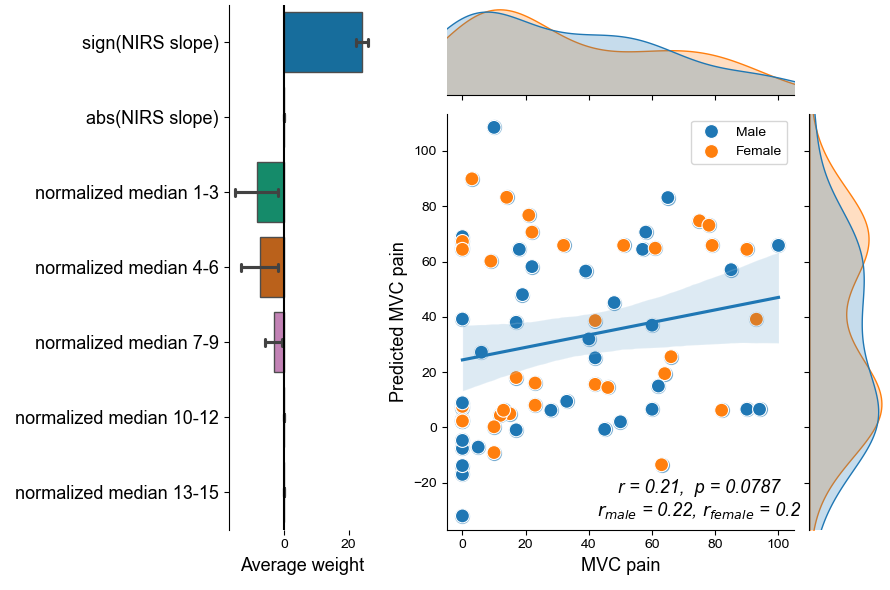

In [15]:
modality = 'NIRS'
target = 'MVC pain'
plot_predictions(coefs_nirs, target_df_nirs, modality, target, plot_path=None, save_plot=False)

Training the model based on EMG features:

In [16]:
target_df_emg, scores, coefs_emg, feature_imp, corr, p_val, best_model, support = regression_fit(np.c_[np.sign(sample_entropy['ent_coef_task']), np.abs(sample_entropy['task_ent'][:,14]-sample_entropy['task_ent'][:,0]), np.sign(wt_coef_task)], np.c_[pain_rm, sub_sex], model='PLSc',
                                                                   plot_path=None, feature_labels=feature_labels, num_iter=1, max_iter=1000000, plot_pred=False,
                                                                   plot_weight=False, save_plot=False, feature_selection=True, selection_method='single', 
                                                                   inner_k=10, outer_k=10, feature_type='EMG', target='pain_rm')

iteration 1 started
processing fold: 1
# selected features:  4
fold 1 took 0.499 seconds

processing fold: 2
# selected features:  3
fold 2 took 0.433 seconds

processing fold: 3
# selected features:  3
fold 3 took 0.434 seconds

processing fold: 4
# selected features:  3
fold 4 took 0.436 seconds

processing fold: 5
# selected features:  3
fold 5 took 0.433 seconds

processing fold: 6
# selected features:  4
fold 6 took 0.499 seconds

processing fold: 7
# selected features:  2
fold 7 took 0.354 seconds

processing fold: 8
# selected features:  3
fold 8 took 0.431 seconds

processing fold: 9
# selected features:  4
fold 9 took 0.498 seconds

processing fold: 10
# selected features:  4
fold 10 took 0.499 seconds



modality:  EMG


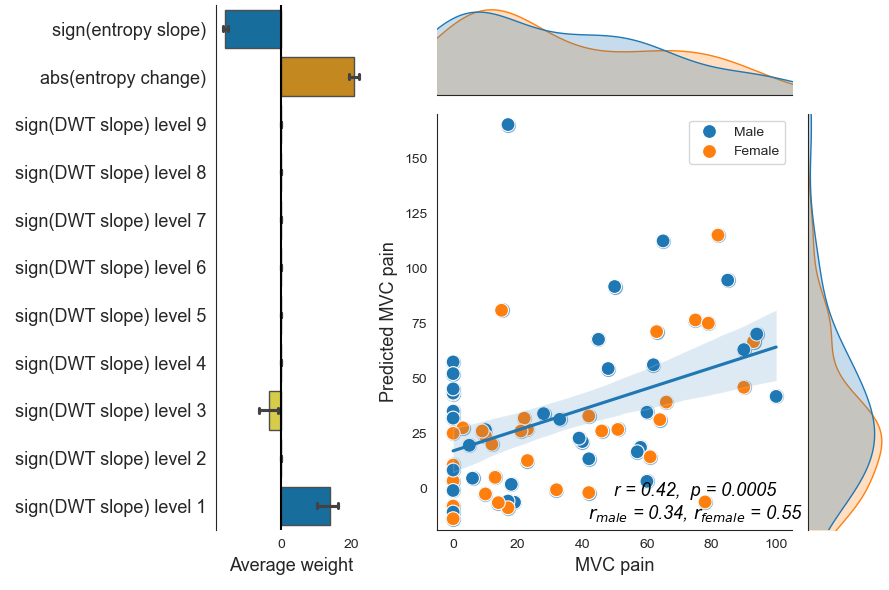

In [17]:
modality = 'EMG'
target = 'MVC pain'
plot_predictions(coefs_emg, target_df_emg, modality, target, plot_path=None, save_plot=False)

Training the model based on NIRS and EMG features:

In [25]:
target_df, scores, coefs, feature_imp, corr, p_val, best_model, support = regression_fit(np.c_[np.sign(diff_coef), np.abs(diff_coef), np.mean(task_median.reshape(-1, 3),
                                                                                axis=1).reshape(-1,5) - np.expand_dims(pre_rest_median, axis=1),
                                                                                np.sign(sample_entropy['ent_coef_task']), np.abs(sample_entropy['task_ent'][:,14]-sample_entropy['task_ent'][:,0]), np.sign(wt_coef_task)],
                                                                                np.c_[pain_rm, sub_sex], model='PLSc',
                                                                                plot_path=None, feature_labels=feature_labels, num_iter=1, max_iter=1000000, plot_pred=False,
                                                                                plot_weight=False, save_plot=False, feature_selection=True, selection_method='single',
                                                                                inner_k=10, outer_k=10, feature_type='NIRS_EMG', target='pain_rm')

iteration 1 started
processing fold: 1
# selected features:  6
fold 1 took 1.075 seconds

processing fold: 2
# selected features:  5
fold 2 took 0.958 seconds

processing fold: 3
# selected features:  8
fold 3 took 1.277 seconds

processing fold: 4
# selected features:  7
fold 4 took 1.176 seconds

processing fold: 5
# selected features:  5
fold 5 took 0.957 seconds

processing fold: 6
# selected features:  6
fold 6 took 1.07 seconds

processing fold: 7
# selected features:  5
fold 7 took 0.955 seconds

processing fold: 8
# selected features:  6
fold 8 took 1.075 seconds

processing fold: 9
# selected features:  6
fold 9 took 1.072 seconds

processing fold: 10
# selected features:  8
fold 10 took 1.274 seconds



modality:  NIRS_EMG


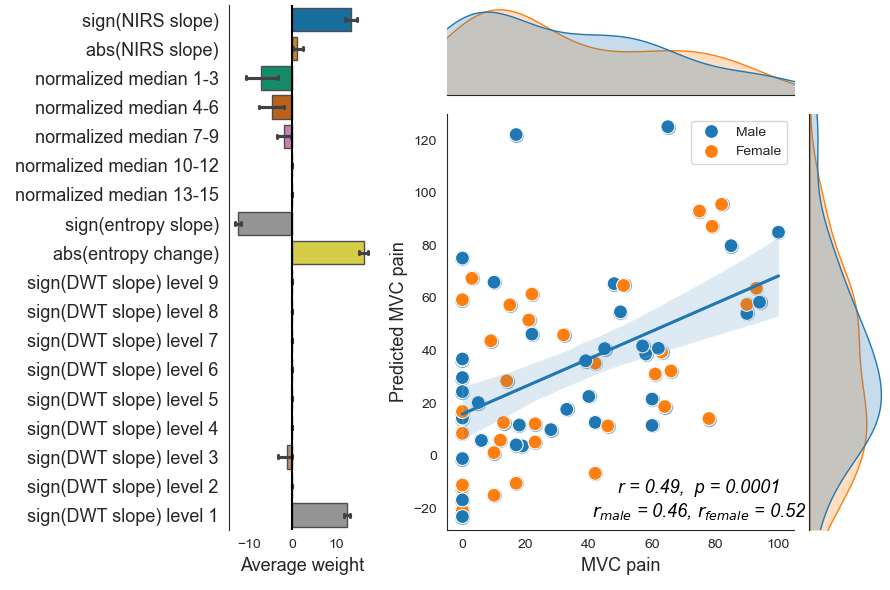

In [30]:
modality = 'NIRS_EMG'
target = 'MVC pain'
plot_predictions(coefs, target_df, modality, target, plot_path=None, save_plot=False)

## Selected features

Training 1000 models (100 iteration, 10 fold cross-validation) and counting how many times each feature is selected by the algorithm:

In [19]:
target_df_fs, scores, coefs_fs, feature_imp, corr, p_val, best_model, support = regression_fit(np.c_[np.sign(diff_coef), np.abs(diff_coef), np.mean(task_median.reshape(-1, 3),
                                                                                axis=1).reshape(-1,5) - np.expand_dims(pre_rest_median, axis=1),
                                                                                np.sign(sample_entropy['ent_coef_task']), np.abs(sample_entropy['task_ent'][:,14]-sample_entropy['task_ent'][:,0]), np.sign(wt_coef_task)],
                                                                                np.c_[pain_rm, sub_sex], model='PLSc',
                                                                                plot_path=None, feature_labels=feature_labels, num_iter=100, max_iter=1000000, plot_pred=False,
                                                                                plot_weight=False, save_plot=False, feature_selection=True, selection_method='single',
                                                                                inner_k=10, outer_k=10, feature_type='NIRS_EMG', target='pain_rm')

iteration 1 started
processing fold: 1
# selected features:  6
fold 1 took 1.093 seconds

processing fold: 2
# selected features:  5
fold 2 took 0.952 seconds

processing fold: 3
# selected features:  8
fold 3 took 1.279 seconds

processing fold: 4
# selected features:  7
fold 4 took 1.183 seconds

processing fold: 5
# selected features:  5
fold 5 took 0.956 seconds

processing fold: 6
# selected features:  6
fold 6 took 1.072 seconds

processing fold: 7
# selected features:  5
fold 7 took 0.96 seconds

processing fold: 8
# selected features:  6
fold 8 took 1.078 seconds

processing fold: 9
# selected features:  6
fold 9 took 1.076 seconds

processing fold: 10
# selected features:  8
fold 10 took 1.288 seconds

iteration 2 started
processing fold: 11
# selected features:  4
fold 11 took 0.836 seconds

processing fold: 12
# selected features:  6
fold 12 took 1.087 seconds

processing fold: 13
# selected features:  8
fold 13 took 1.283 seconds

processing fold: 14
# selected features:  5

# selected features:  8
fold 112 took 1.28 seconds

processing fold: 113
# selected features:  5
fold 113 took 0.963 seconds

processing fold: 114
# selected features:  5
fold 114 took 1.0 seconds

processing fold: 115
# selected features:  5
fold 115 took 0.97 seconds

processing fold: 116
# selected features:  5
fold 116 took 0.968 seconds

processing fold: 117
# selected features:  4
fold 117 took 0.838 seconds

processing fold: 118
# selected features:  6
fold 118 took 1.079 seconds

processing fold: 119
# selected features:  6
fold 119 took 1.08 seconds

processing fold: 120
# selected features:  8
fold 120 took 1.307 seconds

iteration 13 started
processing fold: 121
# selected features:  7
fold 121 took 1.192 seconds

processing fold: 122
# selected features:  7
fold 122 took 1.217 seconds

processing fold: 123
# selected features:  7
fold 123 took 1.208 seconds

processing fold: 124
# selected features:  5
fold 124 took 1.003 seconds

processing fold: 125
# selected features:  

# selected features:  9
fold 221 took 1.371 seconds

processing fold: 222
# selected features:  6
fold 222 took 1.081 seconds

processing fold: 223
# selected features:  5
fold 223 took 0.96 seconds

processing fold: 224
# selected features:  7
fold 224 took 1.183 seconds

processing fold: 225
# selected features:  8
fold 225 took 1.309 seconds

processing fold: 226
# selected features:  5
fold 226 took 0.978 seconds

processing fold: 227
# selected features:  5
fold 227 took 0.964 seconds

processing fold: 228
# selected features:  4
fold 228 took 0.84 seconds

processing fold: 229
# selected features:  8
fold 229 took 1.436 seconds

processing fold: 230
# selected features:  6
fold 230 took 1.076 seconds

iteration 24 started
processing fold: 231
# selected features:  7
fold 231 took 1.19 seconds

processing fold: 232
# selected features:  5
fold 232 took 0.959 seconds

processing fold: 233
# selected features:  6
fold 233 took 1.078 seconds

processing fold: 234
# selected features:

# selected features:  5
fold 330 took 0.967 seconds

iteration 34 started
processing fold: 331
# selected features:  4
fold 331 took 0.842 seconds

processing fold: 332
# selected features:  9
fold 332 took 1.364 seconds

processing fold: 333
# selected features:  7
fold 333 took 1.186 seconds

processing fold: 334
# selected features:  5
fold 334 took 0.962 seconds

processing fold: 335
# selected features:  5
fold 335 took 0.962 seconds

processing fold: 336
# selected features:  8
fold 336 took 1.284 seconds

processing fold: 337
# selected features:  7
fold 337 took 1.183 seconds

processing fold: 338
# selected features:  7
fold 338 took 1.182 seconds

processing fold: 339
# selected features:  8
fold 339 took 1.31 seconds

processing fold: 340
# selected features:  6
fold 340 took 1.089 seconds

iteration 35 started
processing fold: 341
# selected features:  7
fold 341 took 1.185 seconds

processing fold: 342
# selected features:  6
fold 342 took 1.072 seconds

processing fold: 3

# selected features:  6
fold 438 took 1.079 seconds

processing fold: 439
# selected features:  6
fold 439 took 1.074 seconds

processing fold: 440
# selected features:  4
fold 440 took 0.839 seconds

iteration 45 started
processing fold: 441
# selected features:  6
fold 441 took 1.075 seconds

processing fold: 442
# selected features:  5
fold 442 took 0.965 seconds

processing fold: 443
# selected features:  6
fold 443 took 1.078 seconds

processing fold: 444
# selected features:  5
fold 444 took 0.977 seconds

processing fold: 445
# selected features:  5
fold 445 took 0.958 seconds

processing fold: 446
# selected features:  6
fold 446 took 1.077 seconds

processing fold: 447
# selected features:  8
fold 447 took 1.282 seconds

processing fold: 448
# selected features:  5
fold 448 took 0.981 seconds

processing fold: 449
# selected features:  5
fold 449 took 1.016 seconds

processing fold: 450
# selected features:  5
fold 450 took 0.982 seconds

iteration 46 started
processing fold: 

# selected features:  7
fold 546 took 1.194 seconds

processing fold: 547
# selected features:  5
fold 547 took 0.962 seconds

processing fold: 548
# selected features:  7
fold 548 took 1.195 seconds

processing fold: 549
# selected features:  6
fold 549 took 1.085 seconds

processing fold: 550
# selected features:  5
fold 550 took 0.965 seconds

iteration 56 started
processing fold: 551
# selected features:  7
fold 551 took 1.189 seconds

processing fold: 552
# selected features:  5
fold 552 took 0.971 seconds

processing fold: 553
# selected features:  5
fold 553 took 0.967 seconds

processing fold: 554
# selected features:  6
fold 554 took 1.081 seconds

processing fold: 555
# selected features:  8
fold 555 took 1.3 seconds

processing fold: 556
# selected features:  8
fold 556 took 1.294 seconds

processing fold: 557
# selected features:  6
fold 557 took 1.082 seconds

processing fold: 558
# selected features:  7
fold 558 took 1.19 seconds

processing fold: 559
# selected features:

# selected features:  8
fold 654 took 1.283 seconds

processing fold: 655
# selected features:  5
fold 655 took 0.965 seconds

processing fold: 656
# selected features:  6
fold 656 took 1.088 seconds

processing fold: 657
# selected features:  5
fold 657 took 0.976 seconds

processing fold: 658
# selected features:  6
fold 658 took 1.114 seconds

processing fold: 659
# selected features:  5
fold 659 took 0.994 seconds

processing fold: 660
# selected features:  6
fold 660 took 1.106 seconds

iteration 67 started
processing fold: 661
# selected features:  4
fold 661 took 0.869 seconds

processing fold: 662
# selected features:  5
fold 662 took 0.96 seconds

processing fold: 663
# selected features:  6
fold 663 took 1.082 seconds

processing fold: 664
# selected features:  6
fold 664 took 1.078 seconds

processing fold: 665
# selected features:  5
fold 665 took 0.968 seconds

processing fold: 666
# selected features:  7
fold 666 took 1.182 seconds

processing fold: 667
# selected feature

# selected features:  6
fold 762 took 1.082 seconds

processing fold: 763
# selected features:  5
fold 763 took 0.965 seconds

processing fold: 764
# selected features:  7
fold 764 took 1.182 seconds

processing fold: 765
# selected features:  5
fold 765 took 0.963 seconds

processing fold: 766
# selected features:  8
fold 766 took 1.278 seconds

processing fold: 767
# selected features:  5
fold 767 took 0.956 seconds

processing fold: 768
# selected features:  5
fold 768 took 0.961 seconds

processing fold: 769
# selected features:  7
fold 769 took 1.184 seconds

processing fold: 770
# selected features:  5
fold 770 took 0.962 seconds

iteration 78 started
processing fold: 771
# selected features:  5
fold 771 took 0.967 seconds

processing fold: 772
# selected features:  6
fold 772 took 1.079 seconds

processing fold: 773
# selected features:  8
fold 773 took 1.294 seconds

processing fold: 774
# selected features:  3
fold 774 took 0.7 seconds

processing fold: 775
# selected features

# selected features:  6
fold 870 took 1.081 seconds

iteration 88 started
processing fold: 871
# selected features:  7
fold 871 took 1.177 seconds

processing fold: 872
# selected features:  6
fold 872 took 1.072 seconds

processing fold: 873
# selected features:  6
fold 873 took 1.072 seconds

processing fold: 874
# selected features:  5
fold 874 took 0.959 seconds

processing fold: 875
# selected features:  4
fold 875 took 0.834 seconds

processing fold: 876
# selected features:  5
fold 876 took 0.961 seconds

processing fold: 877
# selected features:  5
fold 877 took 0.979 seconds

processing fold: 878
# selected features:  7
fold 878 took 1.203 seconds

processing fold: 879
# selected features:  8
fold 879 took 1.286 seconds

processing fold: 880
# selected features:  5
fold 880 took 0.961 seconds

iteration 89 started
processing fold: 881
# selected features:  7
fold 881 took 1.182 seconds

processing fold: 882
# selected features:  5
fold 882 took 0.959 seconds

processing fold: 

# selected features:  5
fold 978 took 0.954 seconds

processing fold: 979
# selected features:  5
fold 979 took 0.959 seconds

processing fold: 980
# selected features:  5
fold 980 took 0.958 seconds

iteration 99 started
processing fold: 981
# selected features:  5
fold 981 took 0.976 seconds

processing fold: 982
# selected features:  5
fold 982 took 0.961 seconds

processing fold: 983
# selected features:  8
fold 983 took 1.282 seconds

processing fold: 984
# selected features:  6
fold 984 took 1.074 seconds

processing fold: 985
# selected features:  7
fold 985 took 1.184 seconds

processing fold: 986
# selected features:  7
fold 986 took 1.184 seconds

processing fold: 987
# selected features:  9
fold 987 took 1.38 seconds

processing fold: 988
# selected features:  5
fold 988 took 0.96 seconds

processing fold: 989
# selected features:  8
fold 989 took 1.279 seconds

processing fold: 990
# selected features:  6
fold 990 took 1.077 seconds

iteration 100 started
processing fold: 9

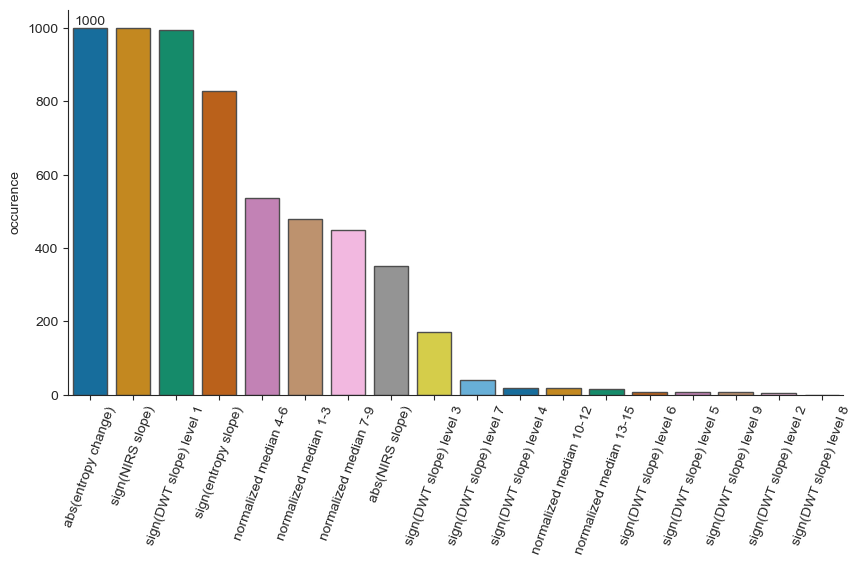

In [38]:
modality = 'NIRS_EMG'
plot_feature_selection(support, modality, plot_path=None, save_plot=False)